# Natural Language Inference

This Jupyter Notebook fine-tunes `microsoft/xlm-roberta-large` on many NLI datasets.
It includes data loading, preprocessing, data augmentation, model training, evaluation, and visualization.

### Environment Setup

This notebook was executed on a local Jupyter server in a LXC connected to 4 GPU: A100 MXP 80GB to train the model.

#### Install dependencies

In [1]:
%pip install -qU pandas numpy seaborn matplotlib scikit-learn datasets
%pip install -qU nltk nlpaug huggingface_hub  # Optional
%pip install -qU "transformers[torch]"

In [2]:
!export PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True

#### Import libraries

In [ ]:
from pathlib import Path
from tqdm import tqdm

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import torch
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset, concatenate_datasets, load_dataset

# Data augmentation
from nlpaug.augmenter.word import RandomWordAug, SynonymAug
from nlpaug.augmenter.char import KeyboardAug

#### Constants

In [4]:
PRETRAINED_MODEL_NAME = "FacebookAI/xlm-roberta-large"
ROOT_PATH = Path.cwd()
MODEL_DIR = ROOT_PATH / "models"
MODEL_BASENAME = PRETRAINED_MODEL_NAME.rpartition('/')[2]

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Use fixed seed for results reproducibility
np.random.seed(0)

### Data Loading

#### Challenge dataset

In [5]:
df = pd.read_csv(ROOT_PATH / "data/train.csv")

# Train-test spliting
challenge_dataset = Dataset.from_pandas(df).train_test_split(test_size=0.3, seed=0)
challenge_train = challenge_dataset['train']
challenge_val = challenge_dataset['test']

# Inspect the train dataset with 10 random row
df.sample(10)

,id,premise,hypothesis,lang_abv,language,label
6543,af77bed638,The experts point out that it is not age alone...,The Qin Dynasty has the most expensive antique...,en,English,1
9150,285d11dd62,Wear a nicely ventilated hat and keep to the s...,A sun umbrella might help those who really nee...,en,English,1
8245,00b1f84085,Each working group met several times to develo...,There were no meetings to discuss changes to t...,en,English,2
3753,e19376a801,farmworkers conducted by the U.S.,A labor survey also considered the views of ag...,en,English,1
713,b0afb96e00,كلمتا blood و flood ليس بنفس صوت food.,الغذاء هو بالضبط مثل الدم والفيضان.,ar,Arabic,2
2799,e33f803e46,"LSC set a deadline of October 1, 1998, for sub...",LSC set a deadline to submit state reports to ...,en,English,1
2335,45280f46e8,"Bila shaka, azimio lako lilikuwa la thamani, S...",Waspania walipanga kukutupa majini wakati wa u...,sw,Swahili,1
2397,0a9e0b89ab,"Eh! Monsieur Lawrence, called Poirot.",Poirot did not call upon Monsieur Lawrence.,en,English,2
3959,f093f8733c,Release 2.0: A Design for Living in the Digita...,Esther Dyson is the Author of Release 2.o: A D...,en,English,0
5808,49ba04c9a8,aCondition Assessment Survey (CAS).,CAS is a Condition Assessment Survey,en,English,0


Display label distribution: the dataset is evenly distributed across all labels.

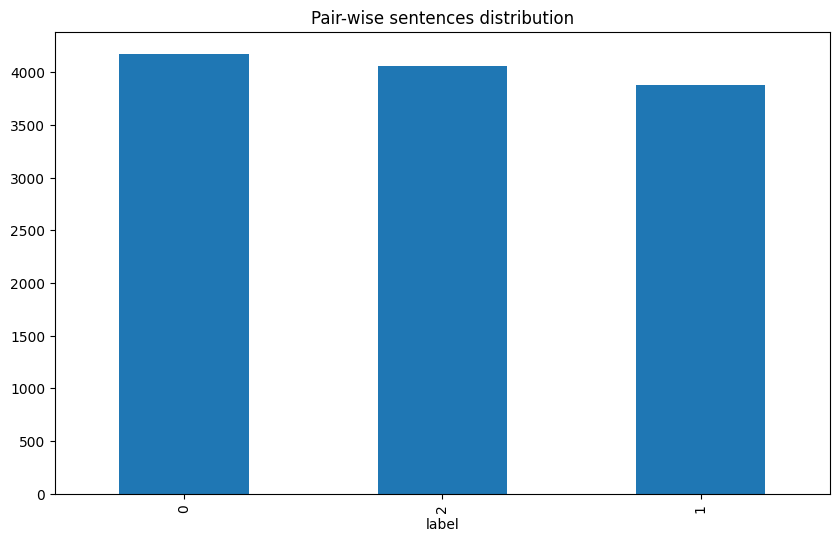

In [6]:
df.label.value_counts().plot(kind="bar", figsize=(10, 6), title="Pair-wise sentences distribution")
plt.show()

However, the dataset predominantly consists of English sentences.

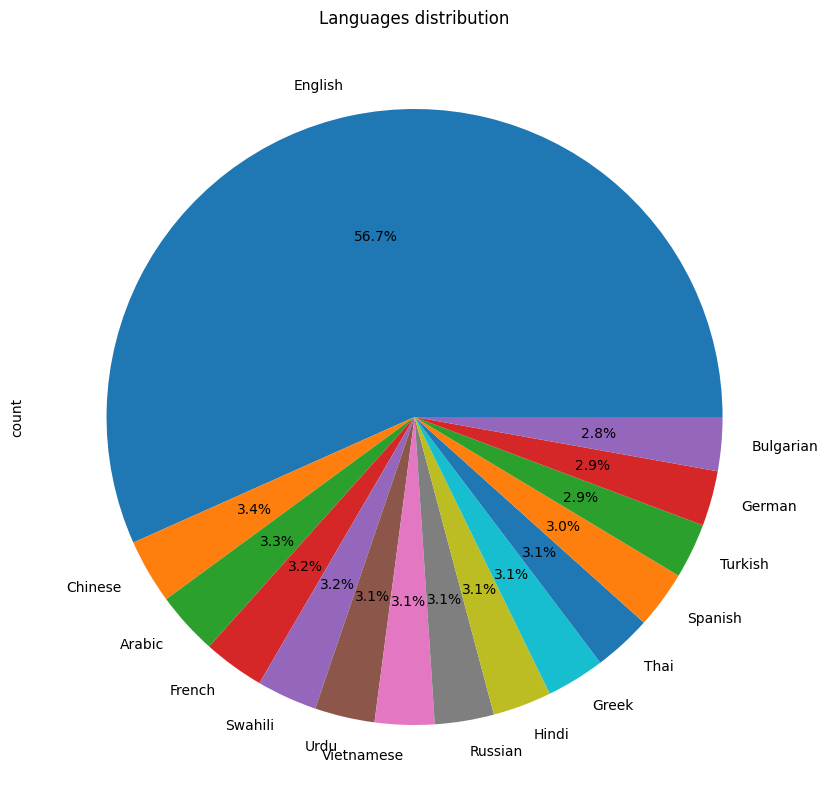

In [7]:
df.language.value_counts().plot(
    kind="pie", 
    figsize=(10, 10), 
    autopct='%1.1f%%', 
    title="Languages distribution"
)
plt.show()

#### MNLI dataset

We use `matched` version of test and train set because the dataset from the Challenge seems to match the same genre.

In [8]:
mnli_train = load_dataset("nyu-mll/glue", "mnli", split="train")
mnli_val = load_dataset("nyu-mll/glue", "mnli", split="validation_matched")

# Inspect the dataset
mnli_train_df = mnli_train.to_pandas()
mnli_train_df.head()

,premise,hypothesis,label,idx
0,Conceptually cream skimming has two basic dime...,Product and geography are what make cream skim...,1,0
1,you know during the season and i guess at at y...,You lose the things to the following level if ...,0,1
2,One of our number will carry out your instruct...,A member of my team will execute your orders w...,0,2
3,How do you know? All this is their information...,This information belongs to them.,0,3
4,yeah i tell you what though if you go price so...,The tennis shoes have a range of prices.,1,4


#### XNLI dataset

[XNLI: Evaluating Cross-lingual Sentence Representations](https://aclanthology.org/D18-1269/) (Conneau et al., EMNLP 2018)

In [9]:
XNLI_TRAIN_SIZE = 1_000_000  # Limit the number of examples as the dataset is very large

def load_xnli_datasets(languages: list, split="train"):
    datasets = []
    for lang in languages:
        xnli_lang = load_dataset("facebook/xnli", lang, split=split)
        xnli_lang = xnli_lang.add_column("lang_abv", [lang] * len(xnli_lang))
        datasets.append(xnli_lang)

    return concatenate_datasets(datasets).shuffle(seed=0)

languages = ['ar','bg','de','el','en','es','fr','hi','ru','sw','th','tr','ur','vi','zh']
xnli_train = load_xnli_datasets(languages, split="train").select(range(XNLI_TRAIN_SIZE))
xnli_val = load_xnli_datasets(languages, split="validation")

Now, we inspect the XNLI dataset.

In [10]:
xnli_train_df = xnli_train.to_pandas()
xnli_train_df.head()

,premise,hypothesis,label,lang_abv
0,"Hardknott का पास , 1 : 3 के अनुपात के साथ , सभ...",यह सभी lakeland गुजरता है .,1,hi
1,No para descartar a esta nueva raza de roquero...,No hay necesidad de descartar por completo a l...,0,es
2,ไม่ว่า จะ ทาง ไหน คุณ ก็ ต้อง จ่าย ใคร สัก คน ...,คุณ กำลัง จ่าย ทั้ง หน่วยงาน หรือ สวนสัตว์,2,th
3,Chỉ có một luật sư và một luật sư trong văn ph...,Chi nhánh lò xo green cove đã xử lý hơn 300 tr...,0,vi
4,一个个 人 的 意愿 接受 ( wta ) 赔偿 不 能 得到 改善 也 是 一 项 有效 ...,一个 人 愿意 接受 补偿 以 代替 改进 是 一 项 可能 的 措施 .,0,zh


### Data Augmentation

Use `NLPAug` library to augment the data by using synonyms, typo insertion and word swapping.

In [11]:
augmenters = [
    (SynonymAug(aug_src='wordnet', aug_p=0.1), 0.8),   # Synonym replacement
    (RandomWordAug(action='swap', aug_p=0.1), 0.1),    # Word swapping
    (KeyboardAug(aug_char_p=0.1, aug_word_p=0.1), 0.3) # Typo simulation
]

def augment_text(text, augmenter):
    try:
        result = augmenter.augment(text)
        # Handle list outputs from some augmenters
        return result[0] if isinstance(result, list) else str(result)
    except Exception as e:
        return str(text)  # Ensure string return

def create_augmented_df(df, augmenters, sample_frac=0.5):
    sample = df.sample(frac=sample_frac)
    augmented = []

    for _, row in tqdm(sample.iterrows(), total=len(sample)):
        for aug, weight in augmenters:
            if np.random.random() > weight:
                continue  # Skip this augmentation

            new_row = row.copy()
            premise = new_row['premise'] = augment_text(row['premise'], aug)
            hypothesis = new_row['hypothesis'] = augment_text(row['hypothesis'], aug)
            if premise != row["premise"] or hypothesis != row["hypothesis"]:
                augmented.append(new_row)

    return pd.DataFrame(augmented).convert_dtypes()

def augment_dataset(ds, augmenters):
    df_aug = create_augmented_df(df, augmenters)
    # Concatenate augmented dataset with original
    ds_aug = Dataset.from_pandas(df_aug)
    return concatenate_datasets([ds, ds_aug]).shuffle()

# challenge_train = augment_dataset(challenge_train, augmenters)

### Tokenizer

Training and evaluation use the `Trainer` API from the `transformers`.

In [12]:
tokenizer = AutoTokenizer.from_pretrained(PRETRAINED_MODEL_NAME)

def tokenize_function(row):
    """Pre-processing class to handle text tokenization."""
    return tokenizer(
        row['premise'], 
        row['hypothesis'],
        padding='max_length', 
        truncation=True, 
        max_length=512
    )
    
def compute_metrics(eval_pred):
    """Compute accuracy on the validation set."""
    y_pred = np.argmax(eval_pred.predictions, axis=1)
    return dict(accuracy=accuracy_score(eval_pred.label_ids, y_pred))

### MNLI Finetuning

Finetune the model on the MNLI dataset.

**Architecture:**  
- `xml-roberta-large` pre-trained model from Hugging Face
- Classification head with dropout (0.3)

In [13]:
# Load the pre-trained model.
model = AutoModelForSequenceClassification.from_pretrained(PRETRAINED_MODEL_NAME, num_labels=3)
model.classifier.dropout = torch.nn.Dropout(0.3)
model.to(device)  # Move model to GPU if available

# Tokenize data
mnli_train_tokenized = mnli_train.map(tokenize_function, batched=True)
mnli_val_tokenized = mnli_val.map(tokenize_function, batched=True)

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/xlm-roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


#### Hyperparameters

In [14]:
mnli_model_dir = MODEL_DIR / f"{MODEL_BASENAME}-mnli"

training_args = TrainingArguments(
    output_dir=mnli_model_dir,
    eval_strategy='epoch',
    save_strategy='epoch',
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    warmup_ratio=0.1,
    load_best_model_at_end=True,
    metric_for_best_model='accuracy',
    report_to='none'  # Disabling wandb callbacks
)

mnli_trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=mnli_train_tokenized,
    eval_dataset=mnli_val_tokenized,
    processing_class=tokenizer,
    compute_metrics=compute_metrics
)

#### Training

In [15]:
mnli_trainer.train()
# Save the best model and the tokenizer to disk.
mnli_trainer.save_model(mnli_model_dir)
tokenizer.save_pretrained(mnli_model_dir)
# Free some unused memory
torch.cuda.empty_cache()

Epoch,Training Loss,Validation Loss,Accuracy
1,0.385600,0.360523,0.866123
2,0.279300,0.351647,0.880591
3,0.175300,0.415775,0.885074


TrainOutput(global_step=36816, training_loss=0.3245165684802384, metrics={'train_runtime': 16814.5915, 'train_samples_per_second': 70.065, 'train_steps_per_second': 2.19, 'total_flos': 7.92505678354401e+17, 'train_loss': 0.3245165684802384, 'epoch': 3.0})

Upload the model to Hugging Face Hub

In [16]:
REPOSITORY_NAME = f"ajayat/{MODEL_BASENAME}-mnli"

mnli_trainer.model.push_to_hub(REPOSITORY_NAME, private=True)
tokenizer.push_to_hub(REPOSITORY_NAME)

### XNLI Finetuning

Finetune the model on the XNLI dataset.

**Architecture:**  
- `xml-roberta-large-mnli` fine-tuned model on MNLI dataset
- Classification head with dropout (0.3)

Train using `Trainer` with same hyperparameters and evaluate the model on the Challenge (train) dataset.

In [17]:
mnli_model_dir = MODEL_DIR / f"{MODEL_BASENAME}-mnli"
# Load the fine-tuned model
mnli_model = AutoModelForSequenceClassification.from_pretrained(mnli_model_dir, num_labels=3)
mnli_model.classifier.dropout = torch.nn.Dropout(0.3)
mnli_model.to(device)

# Tokenize data
xnli_train_tokenized = xnli_train.map(tokenize_function, batched=True)
xnli_val_tokenized = xnli_val.map(tokenize_function, batched=True)

#### Hyperparameters

In [18]:
xnli_model_dir = MODEL_DIR / f"{MODEL_BASENAME}-mnli-xnli"

training_args = TrainingArguments(
    output_dir=xnli_model_dir,
    eval_strategy='epoch',
    save_strategy='epoch',
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=16,
    num_train_epochs=1,
    weight_decay=0.01,
    warmup_ratio=0.1,
    load_best_model_at_end=True,
    metric_for_best_model='accuracy',
    report_to='none'  # Disabling wandb callbacks
)

xnli_trainer = Trainer(
    model=mnli_model,
    args=training_args,
    train_dataset=xnli_train_tokenized,
    eval_dataset=xnli_val_tokenized,
    processing_class=tokenizer,
    compute_metrics=compute_metrics
)

#### Training

In [19]:
xnli_trainer.train()
# Save the best model and the tokenizer to disk.
xnli_trainer.save_model(xnli_model_dir)
tokenizer.save_pretrained(xnli_model_dir)

Epoch,Training Loss,Validation Loss,Accuracy
1,0.440100,0.481936,0.826104


Upload the model to Hugging Face Hub.

In [20]:
REPOSITORY_NAME = f"ajayat/{MODEL_BASENAME}-mnli-xnli"

xnli_trainer.model.push_to_hub(REPOSITORY_NAME, private=True)
tokenizer.push_to_hub(REPOSITORY_NAME)

### Challenge Finetuning

In [ ]:
PRETRAINED_MODEL_NAME = "joeddav/xlm-roberta-large-xnli"
MODEL_BASENAME = PRETRAINED_MODEL_NAME.rpartition('/')[2]
# Load the pre-tuned model from HuggingFace
model = AutoModelForSequenceClassification.from_pretrained(PRETRAINED_MODEL_NAME, num_labels=3)
model.to(device)

# Tokenize data
challenge_train_tokenized = challenge_train.map(tokenize_function, batched=True)
challenge_val_tokenized = challenge_val.map(tokenize_function, batched=True)

Some weights of the model checkpoint at joeddav/xlm-roberta-large-xnli were not used when initializing XLMRobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


#### Hyperparameters

In [ ]:
model_output_dir = MODEL_DIR / f"{MODEL_BASENAME}-finetuned"

training_args = TrainingArguments(
    output_dir=model_output_dir,
    eval_strategy='epoch',
    save_strategy='epoch',
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=16,
    num_train_epochs=5,
    weight_decay=0.01,
    warmup_ratio=0.1,
    load_best_model_at_end=True,
    metric_for_best_model='accuracy',
    report_to='none'  # Disabling wandb callbacks
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=challenge_train_tokenized,
    eval_dataset=challenge_val_tokenized,
    processing_class=tokenizer,
    compute_metrics=compute_metrics
)

#### Training

In [23]:
trainer.train()
# Save the best model and the tokenizer to disk.
trainer.save_model(model_output_dir)
tokenizer.save_pretrained(model_output_dir)

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.247565,0.916667
2,0.532300,0.287248,0.920242
3,0.532300,0.433927,0.919692
4,0.086900,0.477492,0.924367
5,0.086900,0.517755,0.924092


Optional: Upload the model to HuggingFace Hub.

In [ ]:
REPOSITORY_NAME = f"ajayat/{MODEL_BASENAME}-finetuned"

trainer.model.push_to_hub(REPOSITORY_NAME, private=True)
tokenizer.push_to_hub(REPOSITORY_NAME)

### Evaluation & Visualization

Load the model to evaluate and compute accuracy on the challenge validation set.

In [ ]:
FINETUNED_MODEL = f"ajayat/{MODEL_BASENAME}-finetuned"
model = AutoModelForSequenceClassification.from_pretrained(FINETUNED_MODEL, num_labels=3)

training_args = TrainingArguments(
    output_dir="/tmp",
    per_device_eval_batch_size=16,
    report_to='none'
)
trainer = Trainer(model=model.to(device), args=training_args)

# Compute accuracy
pred = trainer.predict(challenge_val_tokenized)
y_true = challenge_val['label']
y_pred = np.argmax(pred.predictions, axis=-1)

accuracy = accuracy_score(y_true, y_pred)
print(f"\nAccuracy: {accuracy:.3f}")


Accuracy: 0.856


Display the confusion matrix using `seaborn`.

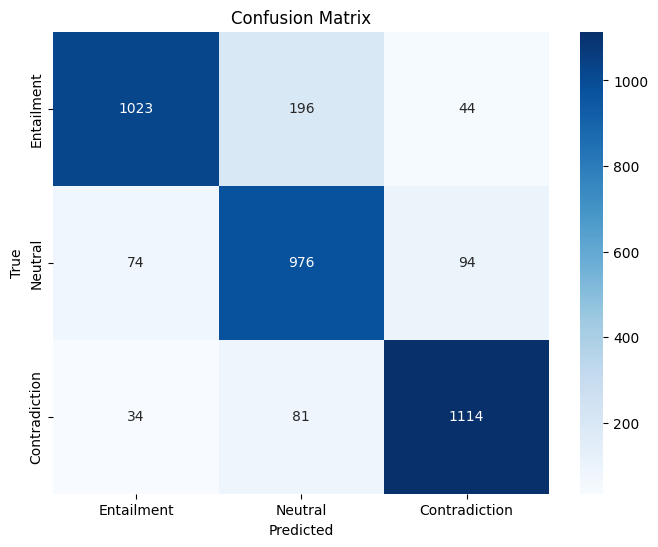

In [25]:
plt.figure(figsize=(8,6))
sns.heatmap(confusion_matrix(y_true, y_pred),
            annot=True,
            fmt='d',
            cmap='Blues',
            xticklabels=['Entailment', 'Neutral', 'Contradiction'],
            yticklabels=['Entailment', 'Neutral', 'Contradiction'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [26]:
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=['Entailment', 'Neutral', 'Contradiction']))


Classification Report:
               precision    recall  f1-score   support

   Entailment       0.90      0.81      0.85      1263
      Neutral       0.78      0.85      0.81      1144
Contradiction       0.89      0.91      0.90      1229

     accuracy                           0.86      3636
    macro avg       0.86      0.86      0.86      3636
 weighted avg       0.86      0.86      0.86      3636



#### Submission file for Kaggle (Optional)

In [ ]:
df_test = pd.read_csv(ROOT_PATH / "data/train.csv")
test_tokenized = Dataset.from_pandas(df_test).map(tokenize_function, batched=True)
# Compute predictions
pred = trainer.predict(test_tokenized)

# Create submission csv file
submission = df_test.id.copy().to_frame()
submission["prediction"] = np.argmax(pred.predictions, axis=1)

submission.to_csv(ROOT_PATH / "data/submission.csv", index=False)
print("\nSubmission file saved.")

### Conclusion

We first fine-tuned a pre-trained model on the full MNLI dataset, followed by further training on a 1M-example subset of the XNLI dataset. This approach gives a validation accuracy of 0.853 on the challenge dataset.

In a separate experiment, we fine-tuned an already pre-trained HuggingFace model `joeddav/xlm-roberta-large-xnli` directly on the challenge dataset. This method achieved a slightly higher test accuracy of 0.914 on the Kaggle competition dataset, placing us 10th on the leaderboard.

#### Beyond

- **Finetuning**: We can try to finetune `xlm-roberta-large` on the full XNLI dataset, which is +5M examples. Or try others hyperparameters.

- **Optimization**: We can use `optimum` and `onnx` libraries to optimize the model for inference, using various optimization techniques such taht `quantization` which speedup the inference time.